In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data=pd.read_csv("./breast-cancer.csv")

diagnosis = {'M': 1, 'B': 0}
data['diagnosis'] = data['diagnosis'].map(diagnosis)

train_data=data.iloc[0:80*len(data)//100]
test_data=data.iloc[80*len(data)//100:]

./breast-cancer.csv
./breastCancer.ipynb


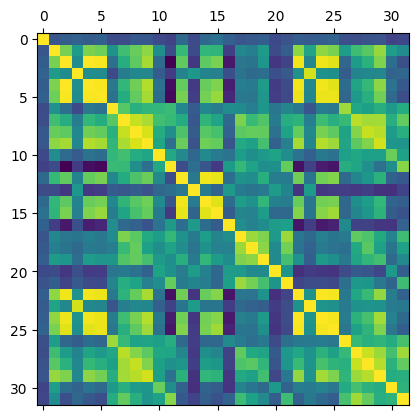

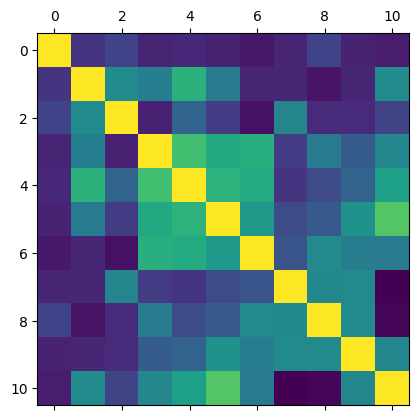

In [2]:
# Find highly correlated columns and remove then for Naive Bayes approach

import matplotlib.pyplot as plt


correlation=data.corr().abs()

plt.matshow(data.corr())
plt.show()

upper = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))

correlationCoefficent=0.7

to_drop = [column for column in upper.columns if any(upper[column] > correlationCoefficent)]

data.drop(to_drop, axis=1, inplace=True)




plt.matshow(data.corr())
plt.show()


In [3]:
features=data.columns
features=features[2:]

data=data[features]
data.head()

,texture_mean,smoothness_mean,compactness_mean,symmetry_mean,fractal_dimension_mean,texture_se,smoothness_se,symmetry_se,symmetry_worst
0,10.38,0.11840,0.27760,0.2419,0.07871,0.9053,0.006399,0.03003,0.4601
1,17.77,0.08474,0.07864,0.1812,0.05667,0.7339,0.005225,0.01389,0.2750
2,21.25,0.10960,0.15990,0.2069,0.05999,0.7869,0.006150,0.02250,0.3613
3,20.38,0.14250,0.28390,0.2597,0.09744,1.1560,0.009110,0.05963,0.6638
4,14.34,0.10030,0.13280,0.1809,0.05883,0.7813,0.011490,0.01756,0.2364


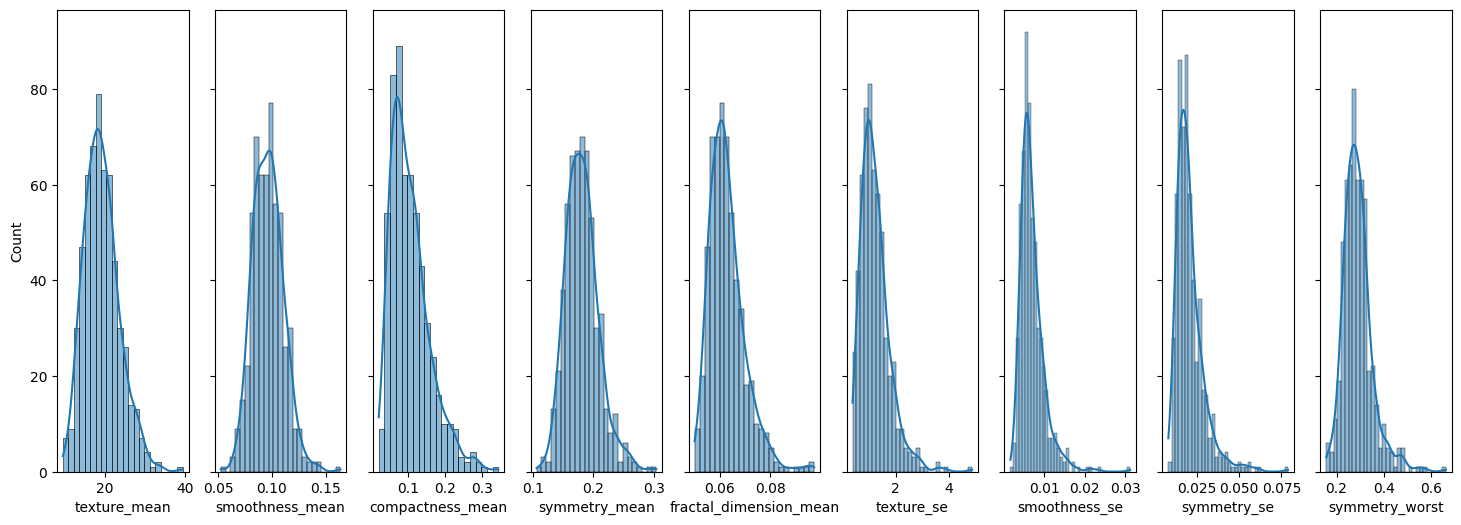

In [4]:
fig, axes = plt.subplots(1, len(features), figsize=(18, 6), sharey=True)
for i in range(len(features)):
    sns.histplot(data, ax=axes[i], x=features[i], kde=True)